### Recurrent Neural Networks

Here we return to our original sequence of historical load data without pivot
the prior hours' data into features as was needed with the regression
techniques.

Moreover, we will not immediately employ the walkforward validation technique due to the time cost of daily retraining. Instead we will train the model to always predict 24 hours out. This simplifies our train/validation/test split as well.

#### TODO predict 1 to 24 hours out

We should train seperate models that predict each of the subsequent 24 hours. These 24 models can be trained independently of each other. This would allow us to train on data that is more recent in the sequence. The hour-ending 24 model will still be trained as above, but the other hours will have a smaller `delay`... but we need the hourly prediction for a particular hour... this approach would just give a "good at `n` hours out" model across the entire day. We could train 1-hour-out models, then do walk forward validation as before...feeding the hourly prediction into the sequence 

In [1]:
%load_ext autoreload
%autoreload 2

from datasets import DataSet

ds = DataSet('data/zone1.parquet', mtlf='LRZ1 MTLF (MWh)', actual='LRZ1 ActualLoad (MWh)')
ds.data.head()

,MSP,DayOfYear,HourEnding,IsBusinessHour,LRZ1 MTLF (MWh),LRZ1 ActualLoad (MWh)
hour,,,,,,
2015-02-01 00:00:00-05:00,23.00,32,1,0,11099,11337.89
2015-02-01 01:00:00-05:00,21.02,32,2,0,10829,11014.87
2015-02-01 02:00:00-05:00,19.04,32,3,0,10565,10795.37
2015-02-01 03:00:00-05:00,19.04,32,4,0,10468,10714.42
2015-02-01 04:00:00-05:00,17.06,32,5,0,10432,10700.09


Since we are predicting 24 hours out, it is acceptable to incorporate the temperature data again, but we will need to normalize. We also will drop our categoricals for now. Can an RNN learn a good model for predicting tomorrow's load from just prior load and temperature sequences? Should we incorporate more temperature sequences?

In [2]:
features = ['MSP', 'IsBusinessHour', ds.actual]
df = ds.data[features].copy()
load = ds.data[ds.actual].copy().to_numpy()

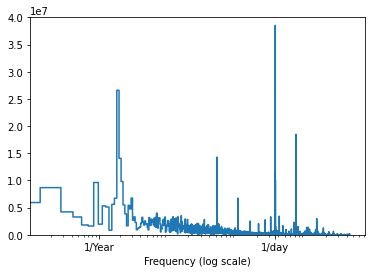

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fft = tf.signal.rfft(load)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(load)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [5]:
f_per_year[np.argwhere(np.abs(fft) > 1e7).flatten()]

array([  0.        ,   1.95471468,   2.09433716,  52.21880642,
       364.27504266, 365.2524    , 366.22975734, 730.5048    ])

Create yearly, daily, bi-daily, and 52 day signals?

In [6]:
import pandas as pd
day = 24*60*60
year = (365.2425)*day
timestamp_s = df.index.to_series().map(pd.Timestamp.timestamp)
df['Twice Day sin'] = np.sin(timestamp_s * (np.pi / day))
df['Twice Day cos'] = np.cos(timestamp_s * (np.pi / day))
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Semiannual sin'] = np.sin(timestamp_s * (np.pi / year))
df['Semiannual cos'] = np.cos(timestamp_s * (np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

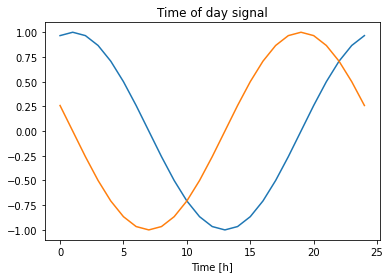

In [7]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [13]:
raw_data = df.to_numpy()
num_test_samples = num_val_samples = 365 * 24
num_train_samples = len(raw_data) - num_test_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [16]:
import numpy as np
from tensorflow import keras

# our input sequence will be seven days of hourly observations
sampling_rate = 1
sequence_length = 24*7

# delay to ensure our predictions don't use intraday information
# we start with 24 hours out
delay = sampling_rate * (sequence_length + 24 - 1) 

batch_size = 64 # hyperparameter
should_shuffle = True

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=load[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=should_shuffle,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [26]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [17]:
from datetime import datetime
def evaluate(model, optimizer="adam", loss="mse", epochs=10, checkpoint_file=None):
    ts = datetime.now().strftime ("%Y%m%d_%H%M%S")
    checkpoint_file = checkpoint_file or f"load_prediction_{optimizer}_{loss}_{ts}.keras"
    callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)]
    model.compile(optimizer=optimizer, loss=loss, metrics=["mae"])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model(checkpoint_file)
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history

from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

In [19]:
x = layers.LSTM(64, unroll=True, return_sequences=True)(inputs)
x = layers.LSTM(64, unroll=True, return_sequences=True)(x)
x = layers.LSTM(64, unroll=True)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
history = evaluate(model, epochs=200)

Epoch 1/200
705/705 [==============================] - 127s 119ms/step - loss: 125459512.0000 - mae: 11085.4131 - val_loss: 113480488.0000 - val_mae: 10523.9531
Epoch 2/200
705/705 [==============================] - 75s 106ms/step - loss: 124419624.0000 - mae: 11038.4131 - val_loss: 112512320.0000 - val_mae: 10477.8574
Epoch 3/200
705/705 [==============================] - 74s 105ms/step - loss: 123408040.0000 - mae: 10992.4990 - val_loss: 111554720.0000 - val_mae: 10432.0596
Epoch 4/200
705/705 [==============================] - 76s 108ms/step - loss: 122404896.0000 - mae: 10946.7705 - val_loss: 110603880.0000 - val_mae: 10386.3838
Epoch 5/200
705/705 [==============================] - 75s 107ms/step - loss: 121407520.0000 - mae: 10901.1230 - val_loss: 109658384.0000 - val_mae: 10340.7725
Epoch 6/200
705/705 [==============================] - 76s 108ms/step - loss: 120415512.0000 - mae: 10855.5205 - val_loss: 108717688.0000 - val_mae: 10295.1855
Epoch 7/200
705/705 [==================

In [23]:
def continue_evaluation(checkpoint_file, epochs=50):
    model = keras.models.load_model(checkpoint_file)
    callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)]
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)
    model = keras.models.load_model(checkpoint_file)
    print(f"Test MAE: {model.evaluate(test_dataset)[1]:2f}")
    return history

In [24]:
history2 = continue_evaluation("load_prediction_adam_mse_20220504_225117.keras")

Epoch 1/50
705/705 [==============================] - 148s 164ms/step - loss: 6711208.5000 - mae: 2149.7417 - val_loss: 4901368.5000 - val_mae: 1750.2310
Epoch 2/50
705/705 [==============================] - 100s 141ms/step - loss: 6533214.0000 - mae: 2115.5173 - val_loss: 4772949.5000 - val_mae: 1724.0306
Epoch 3/50
705/705 [==============================] - 101s 143ms/step - loss: 6359289.0000 - mae: 2081.8450 - val_loss: 4648533.0000 - val_mae: 1698.5626
Epoch 4/50
705/705 [==============================] - 100s 142ms/step - loss: 6189441.0000 - mae: 2048.7346 - val_loss: 4528132.5000 - val_mae: 1673.8281
Epoch 5/50
705/705 [==============================] - 103s 146ms/step - loss: 6023619.0000 - mae: 2016.2349 - val_loss: 4411713.5000 - val_mae: 1649.9249
Epoch 6/50
705/705 [==============================] - 99s 140ms/step - loss: 5861854.0000 - mae: 1984.3519 - val_loss: 4299379.0000 - val_mae: 1626.7046
Epoch 7/50
705/705 [==============================] - 102s 144ms/step - loss:

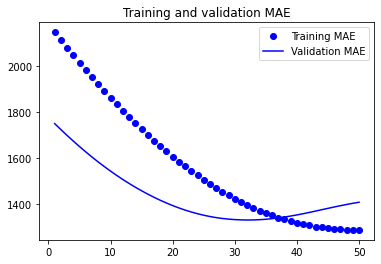

In [25]:
import matplotlib.pyplot as plt
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()